In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import pickle, datetime
import Preprocess as pp

import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import  PIL.Image

Using TensorFlow backend.


## Data Loading

In [3]:
# x_train, y_train, x_test, y_test, N_CATEGORY = pp.load_cat_dog(227, 227, 0.8, 0.2)
x_train, y_train, x_test, y_test, N_CATEGORY = pp.load_cifar101(227, 227, 0.8, 0.2)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(6941, 227, 227, 3) (6941, 101) (1735, 227, 227, 3) (1735, 101) 101


## AlexNet Architecture 

### Model Parameters 

In [4]:
DROPOUT = 0.5
model_input = Input(shape = (227, 227, 3))

# First convolutional Layer (96x11x11)
z = Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = "relu")(model_input)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Second convolutional Layer (256x5x5)
z = ZeroPadding2D(padding = (2,2))(z)
z = Convolution2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = "relu")(z)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Rest 3 convolutional layers
z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = "relu")(z)

z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = Flatten()(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

final_dim = 1 if N_CATEGORY == 2 else N_CATEGORY
final_act = "sigmoid" if N_CATEGORY == 2 else "softmax"
model_output = Dense(final_dim, activation=final_act)(z)

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 256)       0         
__________

In [5]:
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        plt.rcParams["figure.figsize"] = (8,5)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'b')
        pl.plot(self.val_acc, 'g')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

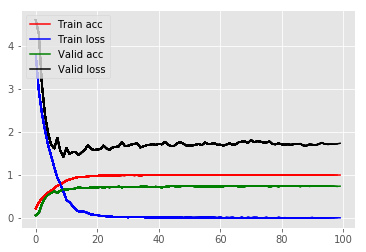

31s - loss: 0.0062 - acc: 0.9990 - val_loss: 1.7371 - val_acc: 0.7406


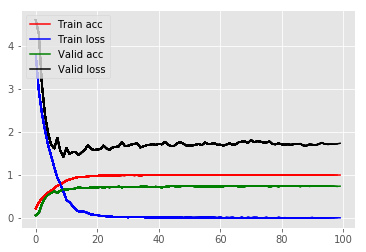

In [6]:
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
BATCH_SIZE = 128
LEARNING_RATE = 0.01
DROPOUT = 0.5
ALPHA = 1e-4
BETA = 0.75
n = 5
k = 2

loss_metric = "binary_crossentropy" if N_CATEGORY == 2 else "categorical_crossentropy"
model.compile(loss=loss_metric, metrics=["accuracy"], 
              optimizer=optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay = WEIGHT_DECAY))

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs=100, 
          validation_data = (x_test, y_test), verbose=2, callbacks=[histories])

In [7]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 99.97%
Test Accuracy: 74.06%


In [8]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './Models/alexNet_catdog_' + '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

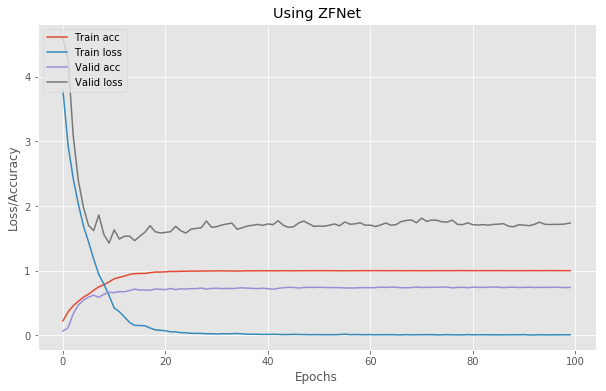

In [9]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using AlexNet')
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()